## Dataset
We will be using the Drug Review Dataset (Drugs.com) for this workshop.

Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125. DOI: [https://dl.acm.org/citation.cfm?doid=3194658.3194677]

It is a part of the UCI machine learning repository.

Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.



In [1]:
import boto3
import pandas as pd
import io
import os
import time
import matplotlib.pyplot as plt
import random
import sagemaker
from sagemaker import get_execution_role
import json
import csv
import pandas as pd

In [2]:
sagemaker_session=sagemaker.Session()
sagemaker_bucket = sagemaker_session.default_bucket()
bucket_name = 'lfs401-2019reinvent-public-cmh'
source_key = 'drugsCom_raw.tsv'
role = get_execution_role()

source_prefix = 'source' 
reviews_data_prefix = 'reviews'

s3_client = boto3.client('s3')
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)

## First, let's explore the source data

In [3]:
def file_size(size):
    splitter = ["B", "KB", "MB", "GB", "TB", "PB"]
    splitter_index = 0
    while size > 1024 and splitter_index < 5:
        splitter_index += 1
        size = size/1024
    size = '{:0.2f}'.format(size)
    return '{}{}'.format(size,splitter[splitter_index])

obj = s3.Object(bucket_name=bucket_name, key=source_prefix + '/' + source_key)
obj_summary = s3.ObjectSummary(bucket_name=bucket_name, key=source_prefix + '/' + source_key)

print(obj.key.split('/')[-1] +', size = '+ file_size(obj_summary.size))


drugsCom_raw.tsv, size = 107.16MB


In [4]:
def load_data_file(file_name, prefix, index_col=None, usecols=None, parse_dates=None):
    response = s3_client.get_object(Bucket=bucket_name, Key=prefix+'/'+file_name)
    response_body = response["Body"].read()
    return pd.read_csv(io.BytesIO(response_body), header=0, delimiter="\t", low_memory=False,
                      index_col=index_col, usecols=usecols, error_bad_lines=False, encoding='utf-8')

In [5]:
note = source_key
print (note)
notes_partial = load_data_file(note, source_prefix)
notes_partial.head()

drugsCom_raw.tsv


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [6]:
notes_partial.shape

(215063, 7)

For the purposes of this demo, we will subselect 50 rows.

In [7]:
notes_50 = notes_partial.sample(n=50)

In [8]:
notes_50.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
214352,65589,Propranolol,mance Anxiety,"""41 year old female that is furious I wasted m...",10.0,"November 27, 2017",5
29255,55663,Effexor,Depression,"""My Doctor is bad and suggested this medicine....",1.0,"October 27, 2016",9
145414,103266,Celecoxib,Osteoarthritis,"""Ive been taking celebrex for a couple of yrs,...",1.0,"November 28, 2016",23
75188,172222,Clonazepam,Panic Disorde,"""I am thankful for this medication clonazepa...",10.0,"October 8, 2017",9
134329,113942,Amlodipine,High Blood Pressure,"""I have been taking Norvasc for probably 30 ye...",1.0,"September 19, 2016",66


## Next, pick the number of topics to use

Now that we have loaded the file, we will pick the number of topics to use. This has three steps:
1. Use Amazon Comprehend Medical to identify topics in each review.
2. Plot the distribution of the number of topics
3. Randomly select the topics from each column


#### Step 1: Identify topics

In [9]:
topic_cnt = 1
cm = boto3.client('comprehendmedical')

topics_per_row = list()

for index,row in notes_50.iterrows():
    topic_list = []
    
    # For each row, use Comprehend Medical to detect entitites
    entities = cm.detect_entities(Text=row['review'])
    time.sleep(1)
    
    # Filter by Medical Condition
    for entity in entities['Entities']:
        if entity['Category'] == 'MEDICAL_CONDITION':
            topic_list.append(entity['Text'])
            topic_cnt += 1
    topic_dict=dict(
        Index=index,
        DrugName=row['drugName'],
        TopicList=topic_list
    )
    topics_per_row.append(topic_dict)
    print (index)
    
    

214352
29255
145414
75188
134329
40549
83055
138824
196356
66252
56298
89467
13222
181744
211800
180011
144572
209322
73024
54042
79302
40384
60446
92717
48699
137768
211347
86589
29862
199030
144908
40935
96673
134322
201401
164646
168484
119426
214085
77883
211979
164364
138990
175822
203940
202423
469
79748
108630
106534


#### Sample Output

In [10]:
topics_per_row[0:5]

[{'Index': 214352,
  'DrugName': 'Propranolol',
  'TopicList': ['mdash', 'trauma', 'worry']},
 {'Index': 29255,
  'DrugName': 'Effexor',
  'TopicList': ['pain',
   'hot flashes',
   'menopause',
   'vomited',
   'hot',
   'cold',
   'dilated',
   'nervous wreak',
   'side headache',
   'muscle ache',
   'feeling sick']},
 {'Index': 145414,
  'DrugName': 'Celecoxib',
  'TopicList': ['tired',
   'tired',
   'fell',
   'hit my ribs',
   'pain',
   'pain',
   'side effect']},
 {'Index': 75188,
  'DrugName': 'Clonazepam',
  'TopicList': ['chronic',
   'episodes',
   'panic attack',
   'falling',
   'sweating',
   'die',
   'panic attacks']},
 {'Index': 134329,
  'DrugName': 'Amlodipine',
  'TopicList': ['feeling pretty good',
   'pain',
   'feeling pressure',
   'migraine headaches',
   'migraines']}]

#### Step 2: Plot topic distribution

Text(0.5, 0, 'Number of topics')

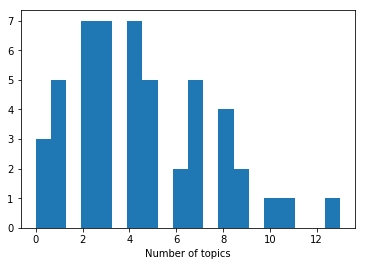

In [11]:
topic_count = [ len(_['TopicList']) for _ in topics_per_row]
plt.hist(topic_count,bins=20,label='Topic Count')
plt.xlabel('Number of topics')

#### Step 3: Create topic list and review the output. In this example, we only use reviews with at least 5 germane topics

In [12]:
reviews=pd.DataFrame(columns=['drugName','topic1','topic2','topic3','topic4','topic5'])
min_topic_len = 5

for row in topics_per_row:
    topic_list = row['TopicList']
    if len(topic_list) >= min_topic_len:
        # Randomly select topics
        random_topics = random.choices(topic_list, k=min_topic_len)
        reviews=reviews.append({
            'drugName' : row['DrugName'],
            'topic1' : str(random_topics[0]),
            'topic2' : str(random_topics[1]),
            'topic3' : str(random_topics[2]),
            'topic4' : str(random_topics[3]),
            'topic5' : str(random_topics[4])},
            ignore_index=True)

In [13]:
reviews.head()

,drugName,topic1,topic2,topic3,topic4,topic5
0,Effexor,vomited,nervous wreak,feeling sick,muscle ache,feeling sick
1,Celecoxib,pain,tired,fell,side effect,tired
2,Clonazepam,sweating,die,panic attack,episodes,episodes
3,Amlodipine,migraine headaches,pain,migraine headaches,pain,migraine headaches
4,Ganciclovir,infection,infection,difficult to get the drop,sensitive to light,difficult to get the drop


*Now get the number of reviews that met the criteria*

In [14]:
reviews.shape


(21, 6)

#### Now that the topics have been generated, save a CSV on both local disk as well as Amazon S3

In [15]:
reviews.to_csv('reviews_50.csv',header=True, index=False)

In [16]:
s3_client.upload_file('reviews_50.csv', sagemaker_bucket, reviews_data_prefix+'/reviews_50.csv' )

# Batch preparation of drug name/topics

Running a large number of calls serially through Amazon Comprehend Medical is, of course, inefficent. Comprehend Medical gives you the ability to batch process millions of notes in a single API call. For a high level overview, see https://aws.amazon.com/blogs/aws/introducing-batch-mode-processing-for-amazon-comprehend-medical/.

## N.B. If you run the Comprehend Medical batch calculation across the entire dataset, you may incure charges, and the full analysis will complete after this workshop is complete. Do not do this as part of the workshop. We have provided files for you.

Here are the steps to do this for this data set:
1. For each line, extract the review and convert it to a JSON file named `<drug_id>.json` with the form `{"Text": "...review..."}`.
2. Upload each of the files to S3 with a shared key space. For example: 
```
lfs401-data/json/112.json
lfs401-data/json/3528.json
```
3. Use Amazon Comprehend Medical Batch Mode to process the files. You can either use the console or the Comprehend Medical API. Save the output to a different key space. The job is submitted asynchronously so you can poll for the job status.
4. Once the job is complete, you can access all the files in S3. Pull them back down to your instance to continue.


## The post-processing is covered below. Resume with the following cell.



Download the output zip file from S3 and get the output path.

In [17]:
os.getcwd()

'/home/ec2-user/SageMaker'

In [18]:
%%bash
aws s3 cp s3://lfs401-2019reinvent-public-cmh/output.tgz .
aws s3 cp s3://lfs401-2019reinvent-public-cmh/source/drugsCom_raw.tsv source/
tar xzf output.tgz


download: s3://lfs401-2019reinvent-public-cmh/output.tgz to ./output.tgz
download: s3://lfs401-2019reinvent-public-cmh/source/drugsCom_raw.tsv to source/drugsCom_raw.tsv


In [19]:
mypath = os.getcwd()
output_path = os.path.join(mypath,'output', [_ for _ in os.listdir('output') if os.path.isdir(os.path.join('output',_))][0])

print ('Comprehend Medical Output Path: %s' % output_path)
os.chdir(output_path)
os.getcwd()

Comprehend Medical Output Path: /home/ec2-user/SageMaker/output/037062425811-EntitiesDetection-905a864b1f9841b6c379ca3727de0499


'/home/ec2-user/SageMaker/output/037062425811-EntitiesDetection-905a864b1f9841b6c379ca3727de0499'

#### Check number of files - should be 215063

In [20]:
! ls -1 | grep -v Manifest | wc -l

215063


#### Next, iterate through each file. If the file is a valid output name, add it to a dictionary. The file format should look similar to `12345.json.out`, where the numeric value is the id for the entry

In [21]:
def get_topics_from_file(filename):
    with open(filename) as f:
        return json.load(f)

In [22]:
results_dict = dict()
counter = 0
with os.scandir(output_path) as it:
    for entry in it:
        if not (entry.name.startswith('.') or entry.name.startswith('Manifest')) and entry.is_file():
            d = get_topics_from_file(entry)
            id = entry.name.split('.')[0]
            
            results_dict[id] = d
        counter += 1
        if counter % 10000 == 0:
            print (counter)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000


In [23]:
len(results_dict)

215063

#### Read in original files and iterate through to create a list of python dictionaries containing `id`, `drug name`, `condition`, and `review`

In [24]:
filename = 'drugsCom_raw.tsv'
os.chdir(os.path.join(mypath, 'source'))
orig_list = list()

with open(filename) as csvfile:
    myreader = csv.reader(csvfile, delimiter='\t')
    for row in myreader:
        if row[0] == '':
            continue
        else:
            orig_list.append({
                'id': row[0],
                'drugName': row[1],
                'condition': row[2],
                'review': row[3]
            })

#### Confirm the length of the dictionary you lozaded in is the same as in the original file

In [25]:
len(orig_list) == len(results_dict)

True

#### Now, create a list for each entry that contains the index, drug name, and list of topics identified by Comprehend Medical. This is effectively an application inner join on index for `orig_list` and `result_dict`

In [26]:
topics_per_row = list()
topic_count = 1

for entry in orig_list:
    index = entry['id']
    drugName = entry['drugName']
    v = results_dict[index]

    topic_list = []
    for entity in v['Entities']:
        if entity['Category'] == 'MEDICAL_CONDITION':
            topic_list.append(entity['Text'])
            topic_count += 1
    
    topic_dict = dict(
        Index=index,
        DrugName=drugName,
        TopicList=topic_list
    )
    topics_per_row.append(topic_dict)

In [27]:
len(topics_per_row) == len(orig_list)

True

#### Let's look at an example

In [28]:
topics_per_row[0:5]

[{'Index': '206461', 'DrugName': 'Valsartan', 'TopicList': ['side effect']},
 {'Index': '95260',
  'DrugName': 'Guanfacine',
  'TopicList': ['remembering', 'behavior is better']},
 {'Index': '92703',
  'DrugName': 'Lybrel',
  'TopicList': ['light periods', 'side effects', 'side effects']},
 {'Index': '138000',
  'DrugName': 'Ortho Evra',
  'TopicList': ['decreased my libido', 'periods', 'cramps', 'cramps']},
 {'Index': '35696',
  'DrugName': 'Buprenorphine / naloxone',
  'TopicList': ['constipation']}]

#### Now plot a histogram showing the distribution of number of topics per entry

Text(0.5, 0, 'Number of topics')

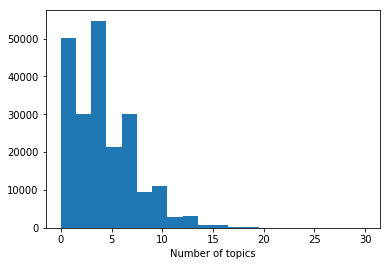

In [29]:
topic_count = [ len(_['TopicList']) for _ in topics_per_row]
plt.hist(topic_count,bins=20,label='Topic Count', range=(0,30))
plt.xlabel('Number of topics')

#### For this example, we select 5 topics per entry. All entries with fewer than 5 relevant topics identified by Comprehend Medical are discarded. This yields ~80k distinct entries. 

In [30]:
%%time

min_topic_len = 5
counter = 0
review_list = []

for row in topics_per_row:
    topic_list = row['TopicList']
    if len(topic_list) >= min_topic_len:
        # Randomly select topics
        random_topics = random.choices(topic_list, k=min_topic_len)
        review_list.append({
            'drugName' : row['DrugName'],
            'topic1' : str(random_topics[0]),
            'topic2' : str(random_topics[1]),
            'topic3' : str(random_topics[2]),
            'topic4' : str(random_topics[3]),
            'topic5' : str(random_topics[4])})
        
reviews = pd.DataFrame(review_list)

CPU times: user 692 ms, sys: 29.2 ms, total: 721 ms
Wall time: 728 ms


In [31]:
reviews.shape

(80050, 6)

In [32]:
reviews.head()

,drugName,topic1,topic2,topic3,topic4,topic5
0,Cialis,headache,hurt,headache,side effects,erections
1,Aripiprazole,moods,hopeless,depression,Bi-polar disorder,depressed
2,Ethinyl estradiol / levonorgestrel,weight gain,weight gain,depression,weight gain,depressed
3,Topiramate,headaches,weight loss,migraines,weight loss,side effect
4,Pentasa,flare,body aching,heart palpitations,narrowing,narrowing


#### Now that we have identified the topics, save the full file, as well as subsamples to S3

In [33]:
def write_files_to_disk_and_s3(bucket_name, s3_uri_base, sample_nums, reviews):
    for sample_num in sample_nums:
        print (sample_num)
        path = 'reviews_%ssample.csv' % str(sample_num)
        write_file_to_disk_and_s3(bucket_name, s3_uri_base, path, sample_num, reviews)
    print ('all reviews')
    write_file_to_disk_and_s3(bucket_name, s3_uri_base, 'reviews_all.csv', reviews.shape[0], reviews)

def write_file_to_disk_and_s3(bucket_name, s3_uri_base, path, sample_num, reviews):
    s3_client = boto3.client('s3')
    s3_key = s3_uri_base.rstrip('/') + '/' + path
    sampled_reviews = reviews.sample(n=sample_num)
    sampled_reviews.to_csv(path, header=True, index=False)
    s3_client.upload_file(path, bucket_name, s3_key)


In [34]:
sample_numbers = [1000, 2000, 5000, 10000, 20000, 50000]
s3_uri_base = 'reviews/'
write_files_to_disk_and_s3(sagemaker_bucket, reviews_data_prefix, sample_numbers, reviews)

1000
2000
5000
10000
20000
50000
all reviews


## Congrats! You are done with data prep. Move to the next notebook.